### Household Sounds Capstone
## 6. Model Analysis

(for model metrics (accuracy, f1score, precision, recall), maybe concat classification report to a list and save as csv)

In [65]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import keras
import tensorflow as tf
from keras.models import Sequential
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU,BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras import Model
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import reciprocal, uniform
from  sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
import matplotlib.image as mpimg

# loading custom functions from custom_funcs.py
from custom_funcs import predictions_with_classification_report, plot_history, plot_confusion_matrix, plot_five

In [66]:
test_audio_dir = './data/FSD50K.eval_audio/'

In [67]:
# loading data
dev_info_resampled = pd.read_json('data/dev_info_resamp.json')
eval_info = pd.read_json('data/labelled_eval_info.json')

validation_info= pd.read_json('data/validation_info.json')
test_info = pd.read_json('data/test_info.json')

In [68]:
class_names_list = ['human', 'noise', 'animal', 'music', 'ambient', 'alarm', 'movement', 'other']
class_labels_dict= {0:'human',1:'noise', 2:'animal', 3:'music', 4:'ambient', 5:'alarm', 6:'movement', 7:'other'}

In [69]:
eval_info.head()

,description,tags,track_num,png_name,labels
391277,An other birds singings recorded on the mornin...,"[birdsong, bird, forest, environment, morning,...",391277,391277.png,2
392115,a snap of one's fingers,"[fingers, finger, 5maudio17, uam, fingersnap]",392115,392115.png,1
411438,A sound of Hot water pouring into a cup,"[fill, can, beverage, glass, water, pour, drin...",411438,411438.png,1
395238,Tearing papers with reverb.\r\n\r\nI used a Sa...,"[ripping, papier, paper, scheuren, rip, tearing]",395238,395238.png,1
425681,i recorded me sighing.,"[sad, happy, sigh]",425681,425681.png,1


## Review of All Model Metrics 


(maybe bring in somewhere the classification report of 1 model with unbalanced classes to point out the class imbalanced problem)
(then just look at model results of balanced classes (refigure out synthetic data at some point)

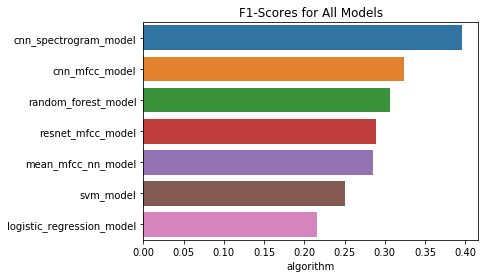

,precision,recall,f1-score
cnn_spectrogram_model,0.382476,0.436457,0.396434
cnn_mfcc_model,0.328554,0.357161,0.324103
random_forest_model,0.302282,0.371758,0.305980
resnet_mfcc_model,0.292270,0.333644,0.289393
mean_mfcc_nn_model,0.304392,0.388999,0.285756
svm_model,0.261212,0.303996,0.250091
logistic_regression_model,0.249118,0.289352,0.215834


In [70]:
# loading model metrics dataframe
metrics_df =pd.read_json('./models/model_metrics_df.json')

# graphing f1-scores by model
sns.barplot(x=metrics_df['f1-score'], y=metrics_df.index, orient='h')
plt.xlabel('algorithm')
plt.title('F1-Scores for All Models')
plt.show()

# displaying metrics dataframe
metrics_df

## Review of Best Model: 
### Algorithm: Convolutional Neural Network <br>Features: Mel-Frequency Spectrograms

#### Here is a review of how that best model, CNN with Spectrograms was trained:

In [71]:
# loading data into generator with keras function .flow_from_directory

datagen=ImageDataGenerator(rescale=1./255.) 

# train generator
train_spectrogram_generator=datagen.flow_from_dataframe(
    dataframe= dev_info_resampled,
    directory= 'data/train_spectrograms',
    x_col='png_name',
    y_col= 'labels', 
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode=  "raw", 
    target_size=(128,216),
    validate_filenames=True) 

# validation generator
val_spectrogram_generator=datagen.flow_from_dataframe(
    dataframe= validation_info,
    directory= 'data/test_spectrograms',
    x_col='png_name',
    y_col= 'labels', 
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode= "raw", 
    target_size=(128,216),
    validate_filenames=True) 

# test generator
test_spectrogram_generator=datagen.flow_from_dataframe(
    dataframe= test_info,
    directory= 'data/test_spectrograms',
    x_col='png_name',
    y_col= 'labels',
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=  "raw", 
    target_size=(128,216),
    validate_filenames=True) 

Found 40000 validated image filenames.
Found 5115 validated image filenames.
Found 5116 validated image filenames.


In [72]:
#Define Model
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(128,216,1))) 
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), padding="same", activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(loss=sparse_categorical_crossentropy, 
              optimizer=SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True), 
              metrics='accuracy')

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 216, 16)      160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 108, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 108, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 54, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 54, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 27, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 27, 32)       

In [73]:
# Instead of retraining this CNN, we will load our trained model

# history = model.fit(x=train_spectrogram_generator, 
#                     validation_data=val_spectrogram_generator, 
#                     epochs=40, 
#                     verbose=1)   

In [74]:
# loading CNN model and model history
model = load_model("./data/cnn_spectrogram_model.h5")
history = pickle.load(open('./data/cnn_spectrogram_model_history.pkl', 'rb'))

classification Report:
              precision    recall  f1-score   support

           0       0.45      0.65      0.53       705
           1       0.70      0.44      0.54      2163
           2       0.35      0.40      0.37       405
           3       0.61      0.71      0.65       562
           4       0.38      0.60      0.46       750
           5       0.26      0.23      0.24       193
           6       0.25      0.43      0.32        44
           7       0.06      0.04      0.05       294

    accuracy                           0.49      5116
   macro avg       0.38      0.44      0.40      5116
weighted avg       0.53      0.49      0.49      5116



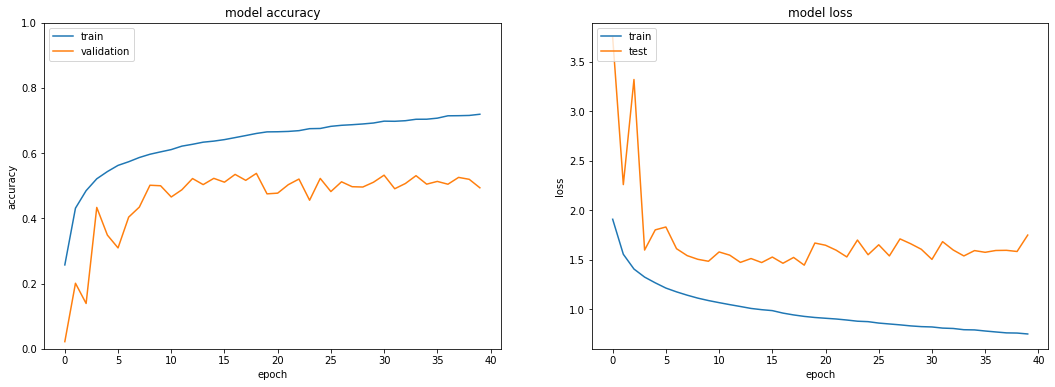

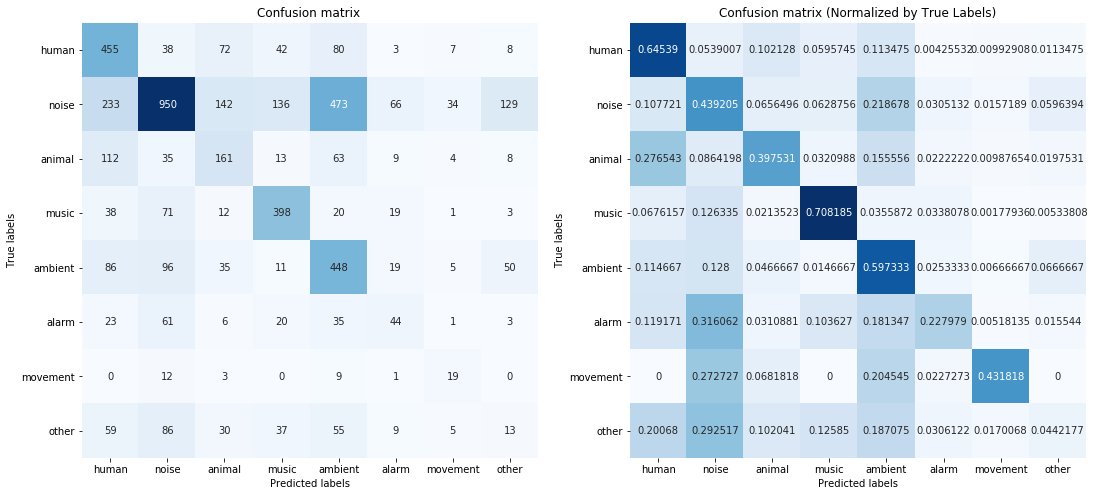

In [76]:
# here is a review of our model analysis from the last notebook:

# making predictions on test data and printing classification report:
spectrogram_preds = predictions_with_classification_report(model=model, 
                                                           generator=test_spectrogram_generator, 
                                                           y_true=test_info.labels)

# plotting model accuracy for training and validation data:
plot_history(history=history)

# plotting a normalizing and non-normalizing confusion matrix::
plot_confusion_matrix(y_true=test_info.labels, y_preds=spectrogram_preds)

## Analysis of Misclassified Audio Files:
- There is not many insights to be found by analyzing correctly predicted audio files, but there it is informative to analyze the incorrect predictions and investigate with what trends the algorithm went wrong.

In [77]:
# making dataframe with true and predicted labels for analysis
pred_df = test_info[['description','tags','png_name','labels']].copy()
pred_df['pred_labels'] = spectrogram_preds
pred_df['correct'] = pred_df['pred_labels'] == pred_df['labels']

# replacing integer labels with string class names on "labels" and "pred_labes" columns
pred_df.labels= pred_df.labels.map(class_labels_dict)
pred_df.pred_labels = pred_df.pred_labels.map(class_labels_dict)

### Slice of Second Lowest F1-Score Category: "other"

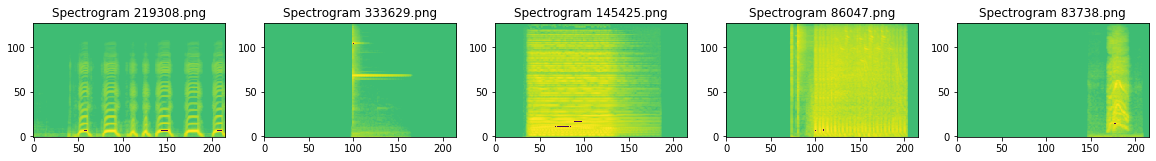

,description,tags,png_name,labels,pred_labels,correct
5508,48 KHz\r\n24 bit,"[cell-phone, ring, iphone, vibrate, mobile-phone]",219308.png,other,human,False
7730,A bar chime,"[note, chime, chimebar]",333629.png,other,noise,False
10123,"A professional quality end/intro/fill effect, ...","[church-organ, film-production, game-developme...",145425.png,other,music,False
6131,machinegun,[machinegun],86047.png,other,noise,False
5202,Multiple people gasping in horror. Recorded o...,"[gasp, group, surpize, walla]",83738.png,other,human,False


In [78]:
five_other_preds = pred_df[(pred_df.labels == 'other') & (pred_df.correct == False)].sample(n=5)
# displaying spectrograms of miscategorized audio file
plot_five(five_other_preds)
# displaying dataframe with true and predicted labels
five_other_preds

### Slice of Second Lowest F1-Score Category: "alarm"

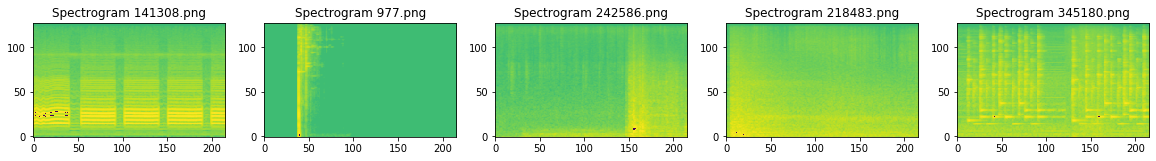

,description,tags,png_name,labels,pred_labels,correct
7337,alarma de maquina retrofuturista,"[alarma, computer, alarm]",141308.png,alarm,music,False
9820,"Stereo recording, small glass being dropped an...","[break, glass, household, small, smash]",977.png,alarm,noise,False
7498,high quality binaural digital recording of a l...,"[thunder, rumble, weather, thunderstorm, thund...",242586.png,alarm,ambient,False
8808,"Sound design of explosion, with dirt and debri...","[bomb, combat, army, war, explode, soldier, ex...",218483.png,alarm,ambient,False
8116,Waking up process alarm.,"[wake-up, alarm, bedroom, morning]",345180.png,alarm,human,False


In [79]:
five_alarm_preds = pred_df[(pred_df.labels == 'alarm') & (pred_df.correct == False)].sample(n=5)
plot_five(five_alarm_preds)
five_alarm_preds

### Slice of Third Lowest F1-Score Category: "movement"

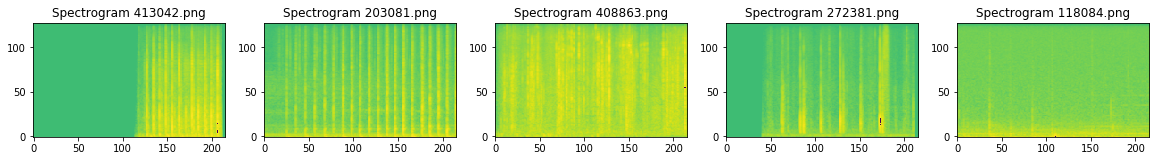

,description,tags,png_name,labels,pred_labels,correct
9822,This sound was created by me for the purpose o...,"[fast, concret, running]",413042.png,movement,noise,False
9141,A person running up and down stairs.,"[running, stairs, fnd112]",203081.png,movement,noise,False
6753,Sound of someone walking on rocks.,"[rocks, owi, gravel, walking, pebbles]",408863.png,movement,noise,False
7228,Footsteps Coming To a Stop,"[a, to, stop, footsteps, coming]",272381.png,movement,animal,False
6567,light footsteps,"[foot, light, steps]",118084.png,movement,ambient,False


In [80]:
five_movement_preds = pred_df[(pred_df.labels == 'movement') & (pred_df.correct == False)].sample(n=5)
plot_five(five_movement_preds)
five_movement_preds

### Business Implications/Recommendations:

### 1. Utilitize Feature Importance to Determine Number of Mel-Frequency Bands to Extract on Future Audio Classification Projects.

- Given the black box nature of Neural Networks and the Support Vector Clasifier coefficients are projected onto another dimensional space, these two models do not have a way calculating feature importance.
- Logistic Regression Model demonstrates feature importance through the magnitude of the model's coefficients. 
- Random Forest Model demonstrates feature importance through its measurement of Gini Impurity. 
- Support Vector Classifier does not domonstrate feauture importance as its coefficients are projected onto an another dimensional space.

In [81]:
# Loading Logistic Regression Model
lr = pickle.load(open('./models/logistic_regression_model.pkl', 'rb'))
# Loading Random Forest Model
rf_random_cv = pickle.load(open('./models/random_forest_model.pkl', 'rb'))

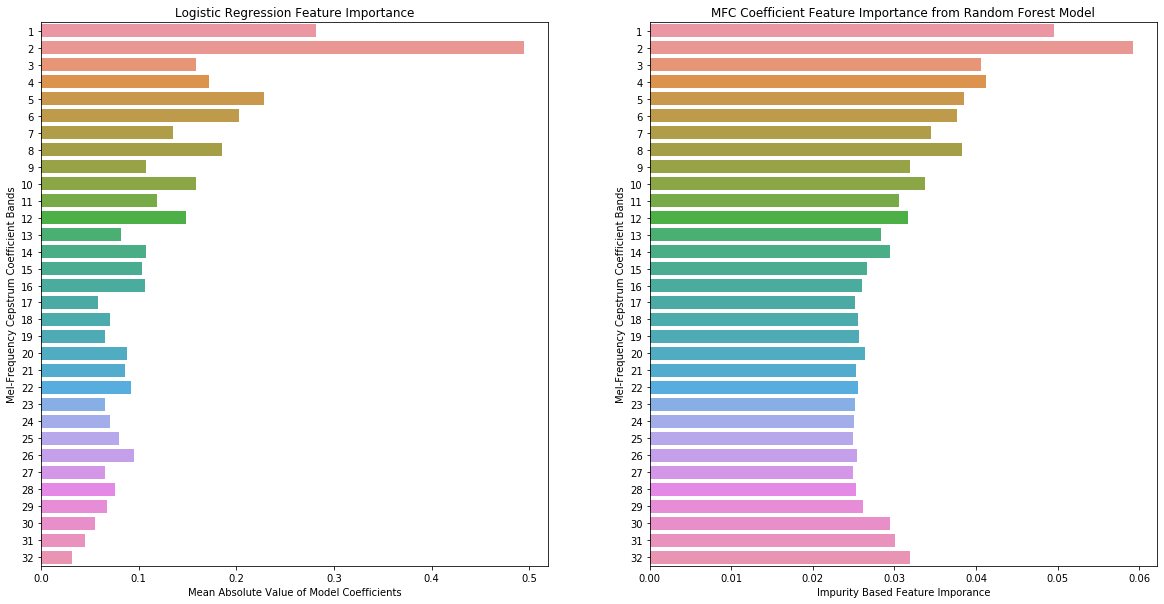

In [82]:
plt.figure(figsize=(20,10))

# Logistic Regression Feature Importance using magnitude of model coefficients:
plt.subplot(121)
sns.barplot(x= np.mean(np.abs(lr.coef_), axis=0), y=list(range(1,33)), orient='h')
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Mean Absolute Value of Model Coefficients')
plt.ylabel('Mel-Frequency Cepstrum Coefficient Bands')

# Random Forest Feature Importance computed as the normalized total reduction
# of the criterion brought by that feature, also known as Gini Importance/Impurity:
plt.subplot(122)
sns.barplot(x=rf_random_cv.best_estimator_.feature_importances_, y=list(range(1,33)), orient='h')
plt.title('MFC Coefficient Feature Importance from Random Forest Model')
plt.xlabel('Impurity Based Feature Imporance')
plt.ylabel('Mel-Frequency Cepstrum Coefficient Bands')
plt.show()
plt.show()

### Analysis: 
- Visual analysis of the Logistic Regression Model does show a drop off of feature importance after the first twelve Mel-Frequency bands. However, all 32 bands still do have coefficients, suggesting that even bands 20-32 are still influencing and improving the model's predicitive capabilities. 
- Visual analysis of the Random Forest Feature Importance suggests that even though the first twelve bands have the highest coefficient values, the last twenty still retain a signficiant level of importance as determined by the Gini Impurity

### Recommendation:
- If one were to train an audio classifier utilizing Mel-Frequency Cepstrum Coefficients as features with the goal of classifying audio samples that contain non-speech audio events, the results from this model would recommend extracting more than the standard 12-13 of Mel-Frequency bands and that extracting 32 Mel-Frequency bands would provide better results
___

### 2. Utilize Mel-Frequency Spectrograms over MFCC Spectrograms for Improved Model Performance

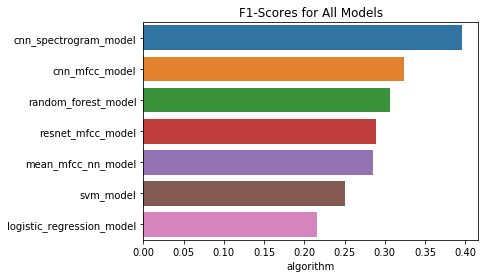

In [123]:
# graphing f1-scores by model
sns.barplot(x=metrics_df['f1-score'], y=metrics_df.index, orient='h')
plt.xlabel('algorithm')
plt.title('F1-Scores for All Models')
plt.show()

### Recommendation:
- A consideration for stakeholders invested in training audio classifiers, the Convolutional Neural Network trained with MF Spectrograms outperformed all other models, including the MFCC CNNs trained with and without ResNet50 transfer learning. 
- While the CNN with MF Spectrograms trained in 97 seconds per epoch compared to the MFCC Spectrograms training time of 24 seconds per epoch, the MF Spectrogram model showed an F1-score improvement by over 7% (32.4%-39.6). 
- If the F1-score is prioritized, the results of this model would recommend using Mel-Frequency Spectrogrms for audio classification over any other feature set.
___

### 3. Use the Best Model's Architecture and Dataset to Train a Classifier that Specifically Predicts for this Model's Highest F1-Score Category: Music

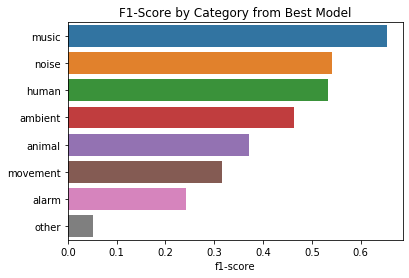

In [125]:
# creating dataframe of classification report from best model:
class_report_df = pd.DataFrame(classification_report(test_info.labels,spectrogram_preds,output_dict=True))\
                              .T.drop(index=['accuracy','macro avg', 'weighted avg'])
class_report_df.index = ['human', 'noise', 'animal', 'music', 'ambient', 'alarm', 'movement', 'other']
class_report_df.sort_values(by='f1-score', ascending=False, inplace=True)

# graphing the F1-Scores
sns.barplot(x=class_report_df['f1-score'], y=class_report_df.index, orient='h')
plt.title('F1-Score by Category from Best Model')
plt.show()

F1-Score for Music Category: 0.652994257588187


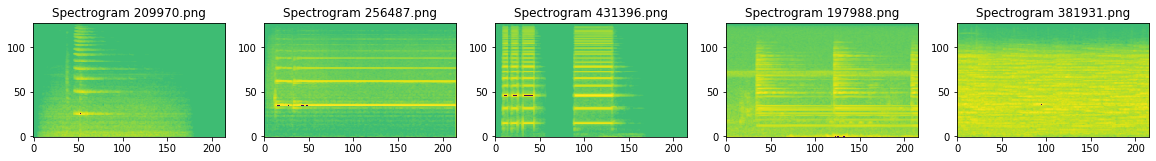

,description,tags,png_name,labels,pred_labels,correct
6597,A train gives a loud whistle before leaving th...,"[delay, horn, beep, whistle, toot, train]",209970.png,music,music,True
5737,a breathy single trumpet note converted to 16-...,"[single-note, short, trumpet]",256487.png,music,music,True
5147,car horn,"[horn, honk, car-horn, car, beep]",431396.png,music,music,True
6000,12pm church bells in a quiet and small village...,"[bells, ambient, field-recording, church]",197988.png,music,music,True
5929,"Recorded on High Street, Oxford, UK. 3rd Janua...","[bells, ringing, church, peal, chime]",381931.png,music,music,True


In [119]:
# a sample of 5 correctly predicted music audio files and their spectrograms
print('F1-Score for Music Category:', class_report_df.loc['music']['f1-score'])
five_music_preds = pred_df[(pred_df.labels == 'music') & (pred_df.correct == True)].sample(n=5)
plot_five(five_music_preds)
five_music_preds

### Recommendation:
- Given the class imbalance of this dataset and this model's high F1-Score, the dataset and this model could tuned for improved performance as a binary audio classifier for musical audio events. 
- The creators of this dataset also created a large dataset with 10 times as  many audio files. The audio files from the expanded dataset could be used to create an improved audio classifier. Classifying specific instruments could be explored.
___

### 4. Apply this Audio Classifier as A Home Security Alert System
### Recommendation:
- The Convolutional Neural Network trained with Spectrogram images could be used as part of a home security system to distinguish between normal ambient sounds and potentially alarming noises.
- This model could flag and alert home owners when there is unwarranted human, movement, or animal noises.
- While the F1-Scores for many of these categories is rather low, this is largely due to the multi-label nature of the audio files. This Convolutional Neural Network model's performance would greatly benefit from an audio dataset with single-label audio events. 
___
___

## Conclusion:
- The best model as evaluated by F1-score was the Convolutional Neural Network trained with Mel-Frequency Spectrogram features.

## Next Steps:
- Improve model accuracy and F1-score by obtaining a larger training dataset.
- Build this classifiation model into an app where a user could record and input raw audio in real time and receive a prediction for the class of the audio event. The user would be able to set alerts for certain unwarranted audio classes and time windows for when those audio events are unwarranted (i.e.human sounds when the user is at work).
- Explore different transfer learning models such as VGG-19 and InceptionV3 .